
XGBoost Model Performance:
  Accuracy: 0.8444444444444444
  Precision: 0.8125
  Recall: 0.7647058823529411
  F1 Score: 0.7878787878787878
  ROC AUC: 0.828781512605042
  Confusion Matrix: [[25, 3], [4, 13]]


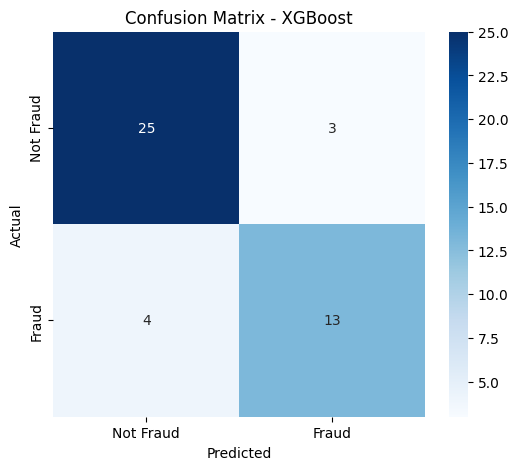


Random Forest Model Performance:
  Accuracy: 0.8888888888888888
  Precision: 0.8
  Recall: 0.9411764705882353
  F1 Score: 0.8648648648648649
  ROC AUC: 0.8991596638655462
  Confusion Matrix: [[24, 4], [1, 16]]


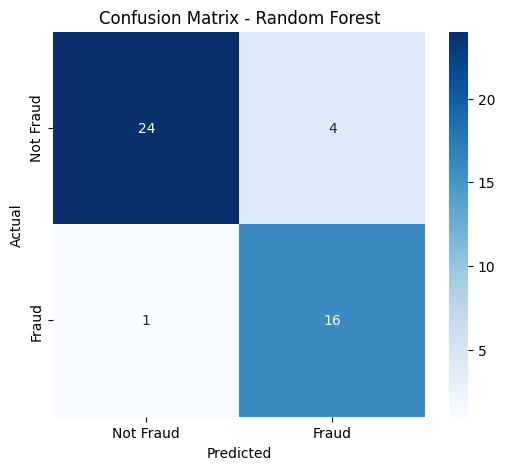


Neural Network Model Performance:
  Accuracy: 0.9111111111111111
  Precision: 0.8421052631578947
  Recall: 0.9411764705882353
  F1 Score: 0.8888888888888888
  ROC AUC: 0.9170168067226891
  Confusion Matrix: [[25, 3], [1, 16]]


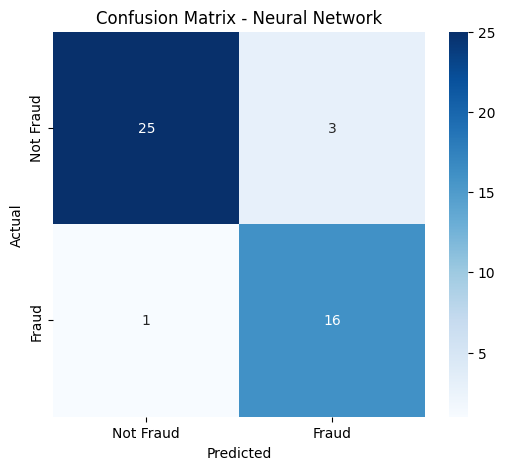

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("fraudulent_claims_dataset.csv")

# Convert Claim_Date to datetime format
df["Claim_Date"] = pd.to_datetime(df["Claim_Date"], errors='coerce')
df.dropna(subset=["Claim_Date"], inplace=True)

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Normalize numerical features
scaler = MinMaxScaler()
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Define features and target
X = df.drop(columns=["Fraud_Label", "Claim_Date"])
y = df["Fraud_Label"]

# Handle class imbalance
smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train models
models = {
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
}

best_model = None
best_accuracy = 0

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist()
    }
    
    if name == "Random Forest":
        best_model = model
        best_accuracy = accuracy

# Save the best model (Random Forest) as a pickle file
with open("Fraudulent_Detection_Model.pkl", "wb") as file:
    pickle.dump(best_model, file)

# Display performance
for name, performance in results.items():
    print(f"\n{name} Model Performance:")
    for metric, value in performance.items():
        print(f"  {metric}: {value}")

    # Plot confusion matrix
    conf_matrix = np.array(performance["Confusion Matrix"])
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
